Inspired by the 'Data Science for Statups' post which used a Google BigQuery sample dataset:<br><br>
https://towardsdatascience.com/data-science-for-startups-exploratory-data-analysis-70ac1815ddec<br><br>
That Medium post was coded in R. I tried to re-create some of the analysis in Python (although I  didn't re-create the analysis exactly). Some things covered in this notebook:
* setting up a bigquery client
* querying a bigquery dataset and importing the data to a pandas dataframe
* a few interesting plots using matplotlib and seaborn
* how we might use the plots above to derive health / birth trends from the data


In [7]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time
import numpy as np

%matplotlib inline

Background, what is BigQuery:
* https://cloud.google.com/bigquery/<br>
Getting started, see the docs:
* https://cloud.google.com/bigquery/docs/
* https://google-cloud-python.readthedocs.io/en/latest/bigquery/reference.html<br>
Import library for python:
* https://cloud.google.com/bigquery/docs/reference/libraries<br>

Below is the Project ID I set up here: https://console.cloud.google.com/apis/ and enabled BigQuery API. When you create a project in Google Cloud you can download the API creditials as a json file. The json file will be required for to create a BiqQuery client.

In [2]:
project_id = 'cognizant-192417'

In [3]:
credentials = service_account.Credentials.from_service_account_file('cognizant-fcb24e83ba9f.json')
client = bigquery.Client(credentials= credentials,project=project_id)

I pulled this query from the Medium post here: https://towardsdatascience.com/data-science-for-startups-exploratory-data-analysis-70ac1815ddec

In [8]:
query_job = client.query("""
  SELECT year, plurality, mother_age, father_age,    
       gestation_weeks, ever_born, mother_married, weight_pounds
 FROM `bigquery-public-data.samples.natality`
 order by rand() 
 LIMIT 100000
 """)
t0 = time.time()
results = query_job.result()
t1 = time.time()
print ('query time: {0} seconds'.format(np.round(t1-t0,0)))

query time: 5.0 seconds


interested to see what data type the results variable is...

In [9]:
type(results)

google.cloud.bigquery.table.RowIterator

we can apply a `to_dateframe()` method to our _results_ variable now to work with our data in a dataframe

In [11]:
t0 = time.time()
df = results.to_dataframe()
t1 = time.time()
print ('time to convert bigquery RowIterator variable to dataframe: {0} seconds'.format(
    np.round(t1-t0),0))

time to convert bigquery RowIterator variable to dataframe: 9.0 seconds


I think above the `to_dataframe()` method is populating a dataframe row-by-row. Took 9 seconds for a 100,000 row dataframe, but here's our lovely dataframe that is now easy to work with!

In [12]:
df.head()

,year,plurality,mother_age,father_age,gestation_weeks,ever_born,mother_married,weight_pounds
0,1993,1.0,31,41,39.0,2.0,True,8.501025
1,1969,NaN,25,28,40.0,1.0,None,9.186662
2,1994,1.0,38,35,39.0,5.0,False,8.811877
3,1984,1.0,27,26,39.0,2.0,True,7.936641
4,1973,1.0,24,31,NaN,4.0,True,7.312733


some quick statistics on the table:

In [13]:
df.describe().round(0)

,year,plurality,mother_age,father_age,gestation_weeks,ever_born,weight_pounds
count,100000.0,97300.0,100000.0,100000.0,96492.0,99303.0,99845.0
mean,1991.0,1.0,26.0,39.0,42.0,2.0,7.0
std,11.0,0.0,6.0,25.0,13.0,1.0,1.0
min,1969.0,1.0,11.0,14.0,17.0,1.0,1.0
25%,1982.0,1.0,22.0,25.0,38.0,1.0,7.0
50%,1992.0,1.0,26.0,30.0,39.0,2.0,7.0
75%,2000.0,1.0,30.0,37.0,41.0,3.0,8.0
max,2008.0,5.0,50.0,99.0,99.0,22.0,16.0


Three different ways to do a quick statistical visualization on the birth weight distribution:
1. historgram
    * can play around with the `bins` variable to see how the historgram shape changes
2. cumulative distribution function
3. normalized cumulative distribution function
    * a useful plot I use often to show how the dataset breaks down by percentages

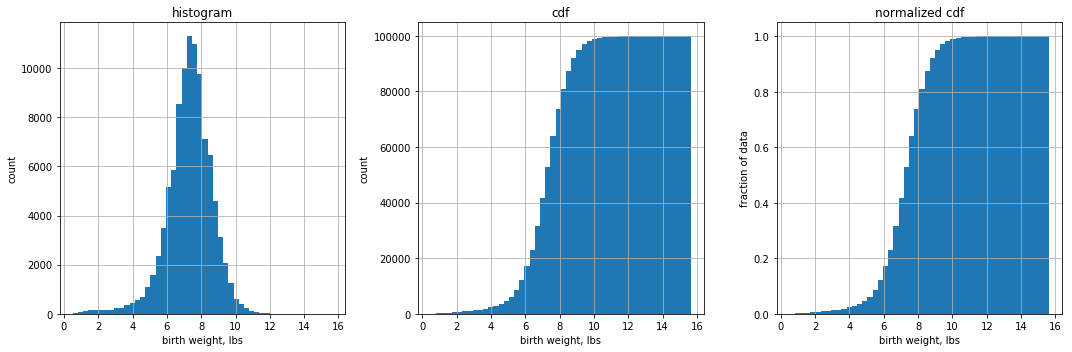

In [18]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
df.weight_pounds.hist(bins=50,ax=ax[0])
ax[0].set_title('histogram');
ax[0].set_xlabel('birth weight, lbs');
ax[0].set_ylabel('count');
df.weight_pounds.hist(bins=50,ax=ax[1],cumulative=True)
ax[1].set_title('cdf');
ax[1].set_xlabel('birth weight, lbs');
ax[1].set_ylabel('count');
df.weight_pounds.hist(bins=50,ax=ax[2],cumulative=True,normed=True)
ax[2].set_title('normalized cdf');
ax[2].set_xlabel('birth weight, lbs');
ax[2].set_ylabel('fraction of data');
plt.tight_layout()

can do something similar in seaborn, and we even get a nice estimated distribution curve with it free of charge ;). Also notice how the seaborn's `displot` by default normalizes the data

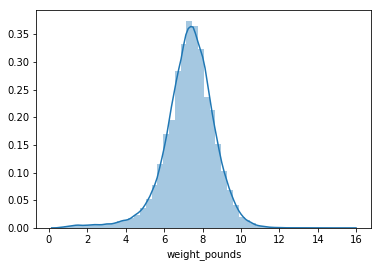

In [22]:
sns.distplot(df.weight_pounds.dropna())

boxplots are useful for visualizing percentile breakdowns. Below we'll see that our 25% - 75% percentile data is pretty tight around 7.5 lbs birth weight. There are query a few outliers however. Birth weights on the high end of the distribution up to ~14lbs could be legit. The data point at ~17.5 lbs seems like a outlier error.

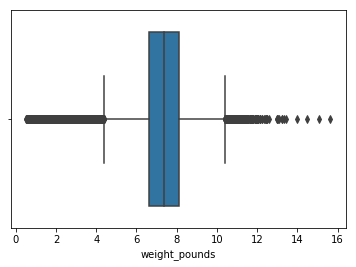

In [23]:
sns.boxplot(df.weight_pounds.dropna())

looking at a distribution of the gestation time (or pregnancy time):

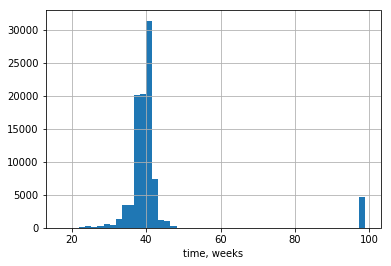

In [26]:
fig,ax = plt.subplots()
df.gestation_weeks.hist(bins=50,ax=ax)
ax.set_xlabel('time, weeks');

clearly some outliers just shy of 100 weeks. Let's get rid of that.

In [34]:
df_mod = df[df.gestation_weeks<80].reset_index(drop=True)

looking at gestation period vs. birth weight

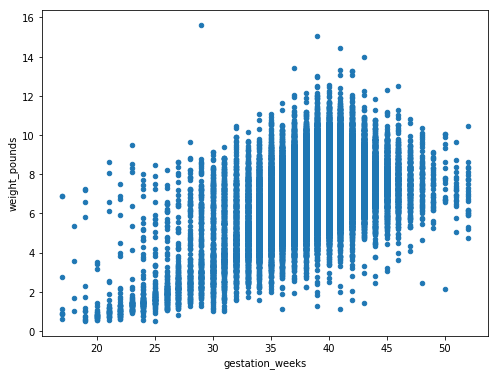

In [38]:
fig,ax = plt.subplots(figsize=(8,6))
df_mod.plot(x='gestation_weeks',y='weight_pounds',kind='scatter',ax=ax)

can see an pretty clear upward trend. Seaborn is nice in that it'll automatically give you an OLS fit on your scatter data when you call the `regplot` method

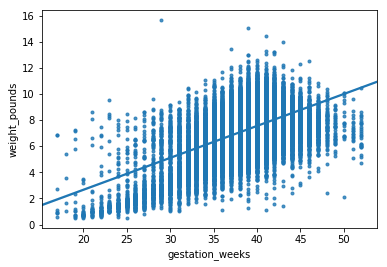

In [39]:
sns.regplot(x='gestation_weeks',y='weight_pounds',data=df_mod,marker='.')

Above is pretty intuitive. The shorter the pregnancy, the lower the birth weight.<br><br>
Another interesting thing we can do is put together a correlation matrix, then plot that with the seaborn `heatmap` function. Highly recommend this page for reference: <https://seaborn.pydata.org/examples/many_pairwise_correlations.html>

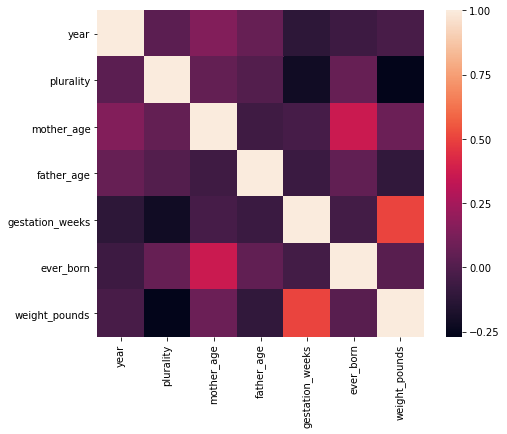

In [41]:
corr_matrix = df_mod.corr()
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix,square=True,ax=ax)

can see that there are two correlations that jump out:
1. gestation_weeks and birth_weight
    * we plotted this above in the scatter and showed the positive linear relationship
2. mother_age and ever_born
    * assuming the ever_born variable represents the number of children the mother previously had. Makes sense that the older the mother, more more children

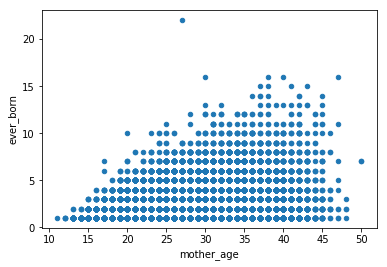

In [49]:
df_mod.plot(x='mother_age',y='ever_born',kind='scatter')

Let's get rid of some of the outliers. 22 children? Going to get rid of datapoints for > 8 babies

In [66]:
df_mod = df_mod[df_mod.ever_born<=10].reset_index(drop=True)

let's look at the average birth weight vs. mother age. We can use the pandas `groupby` method and call the `mean` function on weight_pounds data:

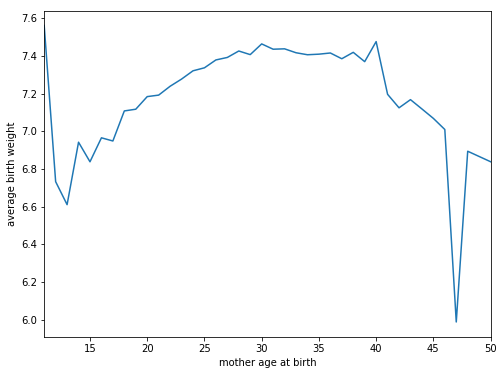

In [67]:
fig,ax=plt.subplots(figsize=(8,6))
df_mod.groupby('mother_age').weight_pounds.mean().plot(ax=ax)
ax.set_ylabel('average birth weight');
ax.set_xlabel('mother age at birth');

curve above looks like it could follow a inverted parabola with a peak birth weight occuring between ages of 30-35 of the mother. For the outliers: 
* the very high birth weight for mother age at birth ~12 years old
    * I imagine the sample size is really small for this age (maybe only 1 entry). We should probably toss it
* the very low dip in birth weight for mother age at 47 years old
    * I'd expect the curve to follow the smooth line. Again, the sample is probably really small for this point and that caused the sudden blip in the curve, and/or there are some really low birth weights in this sample that bring the average down

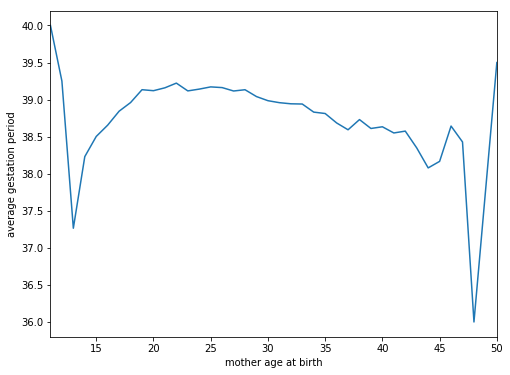

In [68]:
fig,ax=plt.subplots(figsize=(8,6))
df_mod.groupby('mother_age').gestation_weeks.mean().plot(ax=ax)
ax.set_ylabel('average gestation period');
ax.set_xlabel('mother age at birth');

looks like the bulk of the data could be fit to a kind of inverted parabola. We see the outlier sections again at very low and very high mother birthing age. Interestingly we see a steady decline in pregnancy time with higher mother birthing age. And from above, we saw that gestation period was positively correlated with birth weight, the older a woman is when giving birth the lower the expeted birth weight would be.